# Description

This notebook calculates the median (quantile=0.5) scale factors ($\beta$ values) at each location globally and for each month of the year, by regressing annual (3-year-smoothed) global mean surface temperature from HadCRUT (derived and saved out in [hadcrut_GMST.ipynb](./hadcrut_GMST.ipynb)) against that month's median maximum temperature.

We then plot median scale factors around the world, saved out as Supporting Fig. S3.

Scale factors will next be used to scale the climatological distribution to create counterfactual and forced maximum temperature distribution used in the observation-based attribution analysis, see XXXXXXXX.

**FIGURES PRODUCED IN THIS CODE**
* [Fig. S3](./paper_figures/si/figS3.pdf)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utilities as util
import analysisfx as analysis

# ignore depreciation warnings in this code
import warnings
warnings.filterwarnings("ignore")

# define the locations to save the figures into
fig_si_savepath='./paper_figures/si/'

# Load & Organize Data

### Berkeley (land/metric monthly data)

In [2]:
# define the berkeley daily maximum temperature data pathway
berkdpath='./data/berkeley/Berkeley_TMAX_land_188001_201712_daily_N96_365days_degC.nc'
# load in the daily maximum temperature rasters 
bddat=xr.open_dataset(berkdpath)

#### Organize time

In [3]:
# create the datetime grid for Berkeley monthly and daily data
timegridbd=util.get_dt64(bddat)

# add these back into the data structures
bddat['time']=timegridbd

#### Replace 90S invalid data with missing

In [5]:
# set 90S equal to missing
bddat=util.set_N96_SouthPole_missing(bddat,'TMAX')

### GMST (global monthly timeseries, 3-year mean filtered via hadcrut_GMST.ipynb)

In [6]:
# load the data
gmstpath='./data/analysis/GMST-3yrmean.nc'
gmst = xr.open_dataset(gmstpath)
# get the timeseries from 1880-2017
gmstperiod=[1880,2017]
gmst_slice=util.dt64_yrslice(gmstperiod[0],gmstperiod[1])
GMST=gmst['GMST-3yrmean'].sel(time=gmst_slice)

In [7]:
# define the annual timeseries of GMST
# slice to fit the range of the Berkeley data, 
# and reformat for regression below
GMST_annual=(
        GMST.groupby('time.year').mean().sel(year=slice(gmstperiod[0],gmstperiod[-1]))
            .drop('year')
            .rename({"year":"time"})  
        )

### Calculate and Store Monthly medians

Now at every spatial location let's calculate the 50th percentile in each month from the daily data.

In [8]:
# define the median quantile we are calculating over
qi=0.5

In [9]:
# grab each month's data,
# e.g. month_idxs[1] IS JANUARY (idx=0:30,365:395,etc.), and so on for each month
month_idxs=bddat.groupby('time.month').groups
monthsi=np.arange(1,13)

In [10]:
# loop over each of the months in the data set
for mi in monthsi:
    
    # find the median timeseries for a fixed month across the days in that month, for each year
    moni=bddat.isel(time=month_idxs[mi])
    store=moni.groupby('time.year').quantile(qi)
    del moni
    
    # create and assign time index, to assist merging, using central day/time of month as index
    tgrid=bddat['time'].isel(time=month_idxs[mi]).groupby('time.year').map(util.middle_element)
    store2=(
        store
            .assign_coords({'year': tgrid})
            .drop('time')
        )
    del store
    
    # merge into a single dataset
    if mi==1:
        q50i=store2['TMAX']
    else:
        q50i=xr.merge([q50i,store2])
    del store2
    # where are we in the loop?
    print('mon index='+str(mi))

# rename the time dimension
q50=(
    q50i
        .rename_dims({"year":"time"})      
        .rename({"year":"time"})   
    )

# add back in the attributes for maximum temperature
q50['TMAX'].attrs=bddat['TMAX'].attrs

# clean up
del q50i

mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


### Save out q50 dataset

In [11]:
# save out to a netcdf file now that we have the Q50 data array
q50savepath='./data/berkeley/q50_monthly_1880-2017.nc'
q50.to_netcdf(q50savepath)

# Calculate Median Scale Factors ($\beta$): Regress q50 and GMST

We regress median maximum temperatures at every location (and for each month) against GMST, ignoring missing years in the regression. The resulting slope is the scale factor, $\beta$, used to scale the climatological distribution, to arrive at the forced and counterfactual distributions used in the observation-based attribution analysis.

Regression is performed using the **global_xr_regression** function, which is in [utilities.py](./utilities.py).

In [12]:
# find the indices associated with each month
q50monidx=q50.groupby('time.month').groups

# loop over the months
for mi in monthsi:
    
    # subset the median maximum temperature data for the month
    qxy=q50['TMAX'].isel(time=q50monidx[mi])
    
    # get the slopes for this month
    slope_myx=analysis.global_xr_regression(qxy,GMST_annual)
    
    # merge into a single dataset
    if mi==1:
        beta_q50=slope_myx[0].copy(deep=True).assign_coords(month=mi).expand_dims('month')
    else:
        beta_q50=xr.merge([beta_q50,slope_myx[0].copy(deep=True).assign_coords(month=mi).expand_dims('month')])
    del slope_myx
    # where are we in the loop?
    print('mon index='+str(mi))
    
# organize the dataset and its attributes
beta_q50=beta_q50.rename({'TMAX':'beta'})
beta_q50['beta'].attrs={'standard_name': 'regression_scale_factor',
                        'long_name': 'Scale Factor between Monthly TMAX quantiles and annual GMST',
                        'units' : 'unitless ratio',
                       'quantile' : qi}

mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


### Save out Observation-based Median scale factors

In [13]:
# define the location to save the scale factors to
beta_savepath='./data/analysis/q50_beta.nc'
# save the result
beta_q50.to_netcdf(beta_savepath)

# Plot the Result

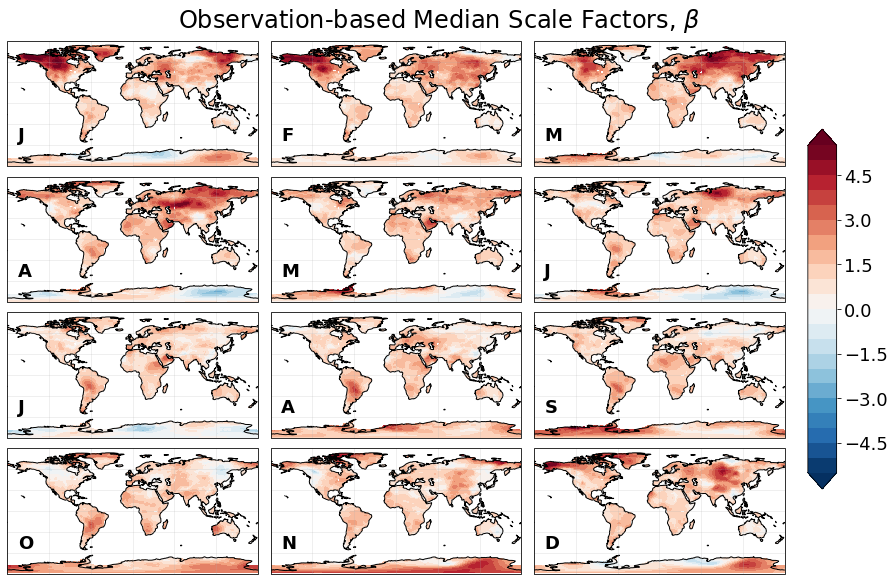

In [19]:
# set up things for the plot
fig=plt.figure(figsize=(16,10))
monstr=['J','F','M','A','M','J','J','A','S','O','N','D']

# loop over all of the months
for mi in monthsi:
    
    # get the name and load data
    beta_m=beta_q50.sel(month=mi)['beta']
    
    # wrap around the prime meridian before plotting
    beta_m_cyc = util.xr_add_cyclic_point(beta_m, 'lon')
    
    # plot the result
    ax = plt.subplot(4, 3, mi, projection=ccrs.PlateCarree())

    levs=np.arange(-5.5,5.5+0.5,0.5)
    datp=ax.contourf(beta_m_cyc.lon,beta_m_cyc.lat,beta_m_cyc, \
                      levels=levs, transform=ccrs.PlateCarree(),cmap='RdBu_r',\
                      extend='both')

    ax.coastlines()
    ax.gridlines(alpha=0.25)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # add the month string
    plt.text(-165,-53,monstr[mi-1],fontsize=18,fontweight='bold',transform=ccrs.PlateCarree())
    
# adjust the white space between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.)

# make a single large colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.5])
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize=18)
fig.colorbar(datp, cax=cbar_ax)

# write the full figure's title
plt.suptitle(r'Observation-based Median Scale Factors, $\beta$', fontsize=24, y=0.92)

plt.show()

# save the plot out
plot_save_name='figS3.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')